In [1]:
import wandb
api = wandb.Api()


In [2]:
_runs_pile_code = api.runs("seperability/seperability-pile-code")
_runs_code_python = api.runs("seperability/seperability-code-python")
_runs_attn = api.runs("seperability/pile-code-attn")
wandb_cache = {}

In [3]:
import re

def extract_name_number_unit(s):
    name = re.search(r'[a-zA-Z ]+', s)
    name = name.group() if name else ''
    
    number = re.search(r'[+-]?\d+(\.\d*)?|\.\d+', s)
    number = float(number.group()) if number else float('inf')
    
    unit = re.findall(r'(?<=[\d.])[a-zA-Z]+', s)
    unit = unit[0] if unit else ''
    unit_value = 0
    if unit.lower() == 'm':
        unit_value = 1
    elif unit.lower() == 'b':
        unit_value = 1000
        
    return (name, number * unit_value, s)


print( extract_name_number_unit('model-1.2M') )

('model', -1.2, 'model-1.2M')


In [8]:
# Just load seaborn & set theme and the chart looks better:
! pip install seaborn -q
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
metric_map = {"base": "Top1", "topk": "Top10", "skip": "Skip50-Top1", "topk_skip": "Skip50-Top10", "loss": "Loss", "perplexity": "Perplexity"}
color_map  = {"pile": "tab:orange", "code": "tab:blue", "python": "tab:green"}
dataset_map = {"pile": "Pile", "pile_codeless": "Pile", "python": "Python", "code": "Code"}
fmt_map = {
    "opt-125m": ":C1",
    "opt-1.3b": "--C1",
    "opt-6.7b": "-C1",
    "galactica-125m": ":C2",
    "galactica-1.3b": "--C2",
    "galactica-6.7b": "-C2",
    "pythia-160m": ":C4",
    "pythia-1.4b": "--C4",
    "pythia-6.9b": "-C4",
}
sns.set_theme()

def is_loss_metric(metric_name):
    if metric_name == "perplexity":
        return True
    if metric_name[-4:] == "loss":
        return True
    return False

def normed(h, dataset, key):
    if key == "perplexity":
        return np.exp(h[f"loss_data/{dataset}/loss"])/np.exp(h[f"loss_data/{dataset}/loss"][0])
    if is_loss_metric(key):
        return h[f"loss_data/{dataset}/{key}"]/h[f"loss_data/{dataset}/{key}"][0]
    return h[f"accuracy/{dataset}/{key}"]/h[f"accuracy/{dataset}/{key}"][0]

def calculate_area(x, y):
    return np.trapz(y, x)

class WandbRunData:
    def __init__(self, run_name):
        self.run_name = run_name.split("https://wandb.ai/")[-1]
        
        if self.run_name in wandb_cache:
            self.run = api.run(self.run_name)
        else:
            self.run = api.run(self.run_name)
            wandb_cache[run_name] = self.run
        
        self.history = self.run.history()
        self.h = self.history
        c = self.run.config
        
        self.model_name = c["model_size"].split("/")[-1].lower()
        
        max_frac = max( c["ff_frac"], c["attn_frac"] )
        self.frac = self.history["_step"] * max_frac
        
        self.cripple, self.focus = c["cripple"], c["focus"]
        self.cripple_label = dataset_map[self.cripple]
        self.focus_label   = dataset_map[self.focus]
        
        # Get "unique" names
        self.name_set = self.focus_label + " " + self.cripple_label
        self.name_set_model = self.name_set + " " + self.model_name
        
    def get_metric(self, metric, diff):
        if is_loss_metric(metric):
            return self.get_loss_metric(metric)
        if diff:
            return self.get_diag_metric(metric)
        return self.get_d_metric(metric)
    
    def get_loss_metric(self, metric):
        self.scale = 1
        focus_perf     = normed(self.h, self.focus,   metric) * self.scale
        cripple_perf   = normed(self.h, self.cripple, metric) * self.scale

        d_focus, d_cripple = focus_perf, cripple_perf
        area = calculate_area(focus_perf, cripple_perf)*2 / (self.scale**2)
        return focus_perf, cripple_perf, area
    
    def get_diag_metric(self, metric):
        self.scale = 100
        focus_perf     = normed(self.h, self.focus,   metric) * self.scale
        cripple_perf   = normed(self.h, self.cripple, metric) * self.scale
        
        d_cripple, d_focus = self.scale-cripple_perf, self.scale-focus_perf
        area = ( calculate_area(d_focus, d_cripple) - self.scale**2/2 )/(self.scale**2)
        return d_cripple, d_focus, area
     
    def get_d_metric(self, metric):
        self.scale = 100
        focus_perf     = normed(self.h, self.focus,   metric) * self.scale
        cripple_perf   = normed(self.h, self.cripple, metric) * self.scale
        
        d_cripple, d_focus = self.scale-cripple_perf, self.scale-focus_perf
        area = calculate_area(d_focus, d_cripple-d_focus)*2 / (self.scale**2)
        return d_cripple, d_focus, area

def plot_frac_pruned(run_obj, metric):
    r = run_obj
    focus_perf     = normed(r.h, r.focus,   metric)
    cripple_perf   = normed(r.h, r.cripple, metric)
    metric_name = metric_map[metric]

    # Begin plotting
    plt.figure()
    plt.plot(r.frac, focus_perf,   label=r.focus_label, color="tab:orange")
    plt.plot(r.frac, cripple_perf, label=r.cripple_label, color="tab:blue")
    plt.fill_between(x, focus_perf, cripple_perf, color="tab:purple", alpha=0.2)
    
    # Add details
    plt.xlim(-0.01, 1)
    plt.ylim(-0.01, None)
    plt.xlabel("Fraction of Model Pruned")
    plt.ylabel("Fraction of Original Accuracy")
    plt.title(f"{metric_name} Accuracy ({r.model_name})")
    plt.legend()
    
    cripple_area = calculate_area(r.frac, cripple_perf)
    focus_area   = calculate_area(r.frac, focus_perf)
    area_ratio = (focus_area-cripple_area)/focus_area
    print(metric_name, "%.3f" % area_ratio)
    
    return area_ratio

def plot_metric(run_obj, metric, diff=True):
    if is_loss_metric(metric):
        return plot_loss_metric(run_obj, metric, diff)
    return plot_perf_metric(run_obj, metric, diff)
    
def plot_perf_metric(run_obj, metric, diff=True): 
    r = run_obj
    d_cripple, d_focus, area = r.get_metric(metric, diff)
   
    # Plot differences in ability 
    metric_name, scale = metric_map[metric], r.scale
    plt.figure(r.name_set+metric_name)
    plt.title(f"{metric_name} Accuracy, {r.cripple_label} Cripple {r.focus_label} Focus")
    #plt.xlim(-scale*0.01, scale*1.01)
    #plt.ylim(-0.01, 1.01)
    plt.xlabel(f"Drop in {r.focus_label} Performance (%)")
    
    if diff:
        plt.ylabel(f"Differential Drop in {r.cripple_label} Performance (∆%)")
        plt.plot(d_focus, d_cripple-d_focus, fmt_map[r.model_name], label=r.model_name)
        plt.plot([0, scale], [0,     0], color="darkgray", linestyle="--", alpha=0.2)
        plt.plot([0, scale], [scale, 0], color="darkgray", linestyle="--", alpha=0.2)
    else:
        plt.ylabel(f"Drop in {r.cripple_label} Performance (%)")
        plt.plot(d_focus, d_cripple, fmt_map[r.model_name], label=r.model_name)
        plt.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.2)
        plt.plot([0, scale], [0,     scale], color="darkgray", linestyle="--", alpha=0.2)
        
    plt.legend()
    
    return area

def plot_loss_metric(run_obj, metric, diff=False):
    r = run_obj
    d_cripple, d_focus, area = r.get_metric(metric, False)
    scale = min([ max([*d_cripple, *d_focus, 1]), 100 ])
   
    # Plot differences in ability 
    metric_name = metric_map[metric]
    fig = plt.figure(r.name_set+metric_name)
    plt.title(f"{metric_name} Accuracy, {r.cripple_label} Cripple {r.focus_label} Focus")
    
    # Custom formatter function for y-axis
    def times_formatter(x, pos):
        return f'{x:.0f}x'    
    plt.xlabel(f"Increase in {r.cripple_label} {metric_name}")
    plt.ylabel(f"Increase in {r.focus_label} {metric_name}")
    plt.loglog(d_cripple, d_focus, fmt_map[r.model_name], label=r.model_name, base=2)
    if scale == 100:
        plt.xlim([0.9, scale*1.01])
        plt.ylim([0.9, scale*1.01])
    ax = fig.gca()
    ax.xaxis.set_major_formatter(FuncFormatter(times_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(times_formatter))
    
    plt.legend()
    
    return area
    
   
from collections import defaultdict 
import pandas as pd
def df_append(df, item: dict):
    new_data = pd.DataFrame({ k:[v] for k,v in item.items() })
    df = pd.concat([ df, new_data ], ignore_index=True )
    return df

def plot_best_metrics(run_names, diff=True):
    #print("model_name", metric_map.values())
    best_run_obj = defaultdict(list)
    df_all = pd.DataFrame()
    for run_name in run_names:
        run_obj  = WandbRunData(run_name)
        run_type = run_obj.name_set_model
        model_name = run_obj.run.config["model_size"].split("/")[-1]
        #run_summary, run_areas = {"name": run_obj.run.name}, {}
        run_summary, run_areas = {"Model": model_name}, {}
        for metric in metric_map.keys():
            _, _, area = run_obj.get_metric(metric, diff)
            run_areas[metric] = area
            if not is_loss_metric(metric):
                run_summary[metric_map[metric]] = area
            #run_summary["url"] = run_obj.run.url
        df_all = df_append( df_all, run_summary )
        best_run_obj[run_type].append( (run_areas["topk_skip"], run_obj, run_summary) )
        
    sort_key = lambda k: extract_name_number_unit(k[0]) 
    
    df = pd.DataFrame() 
    for run_type, run_list in sorted(best_run_obj.items(), key=sort_key):
        _, run_obj, run_summary = sorted(run_list)[-1]
        for metric in metric_map.keys():
            area = plot_metric(run_obj, metric, diff)
            #print(run_obj.model_name, "%.3f" % area)
        df = df_append( df, run_summary )
    
    print(df.to_string(float_format=lambda x:"%.3f"%x))
    plt.show()
    #print(df_all.to_string(float_format=lambda x:"%.3f"%x))
    
def filter_crashed_runs(runs, run_limit=None):
    runs_filtered = []
    for run in runs:
        if run_limit and len(runs_filtered) > run_limit:
            break
        if run.state == "crashed":
            continue
        if not "_step" in run.summary or run.summary["_step"] < 1:
            continue
        runs_filtered.append(run.url)
    return runs_filtered


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


             Model  Top1  Top10  Skip50-Top1  Skip50-Top10
0   galactica-6.7b 0.669  0.716        0.684         0.757
1   galactica-1.3b 0.669  0.735        0.679         0.751
2   galactica-125m 0.406  0.377        0.526         0.591
3         opt-6.7b 0.644  0.639        0.606         0.680
4         opt-1.3b 0.661  0.552        0.640         0.703
5         opt-125m 0.578  0.480        0.567         0.582
6      pythia-6.9B 0.334  0.374        0.393         0.503
7      pythia-1.4B 0.344  0.269        0.482         0.531
8      pythia-160m 0.148  0.106        0.333         0.382
9   galactica-6.7b 0.667  0.713        0.684         0.715
10  galactica-1.3b 0.618  0.537        0.718         0.728
11  galactica-125m 0.575  0.444        0.594         0.534
12        opt-6.7b 0.729  0.698        0.725         0.757
13        opt-1.3b 0.732  0.693        0.740         0.773
14        opt-125m 0.184  0.238        0.620         0.646
15     pythia-6.9B 0.456  0.431        0.455         0.4

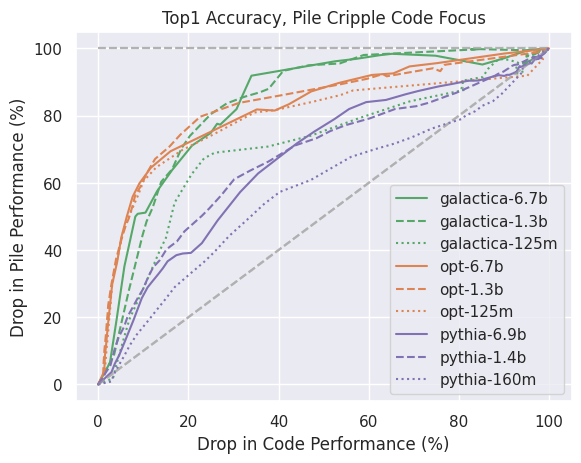

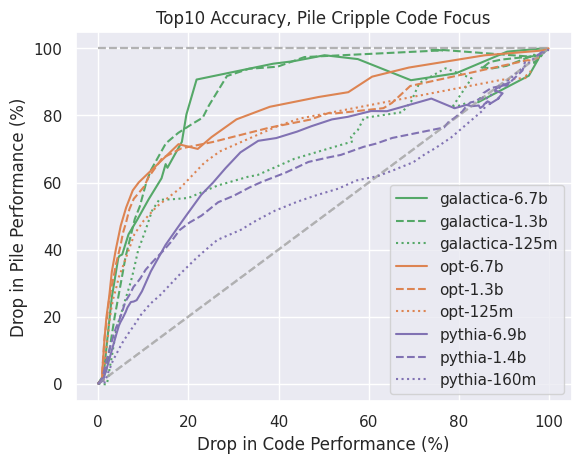

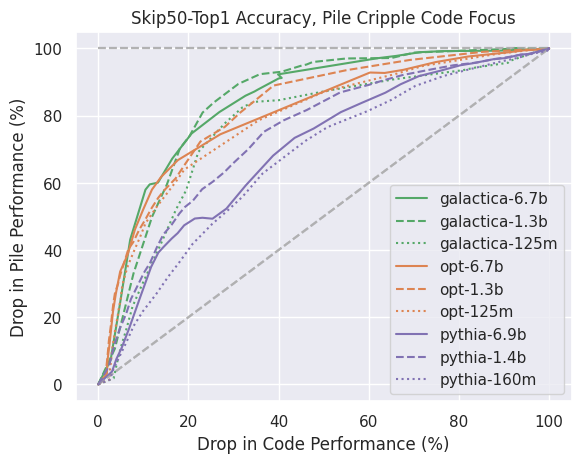

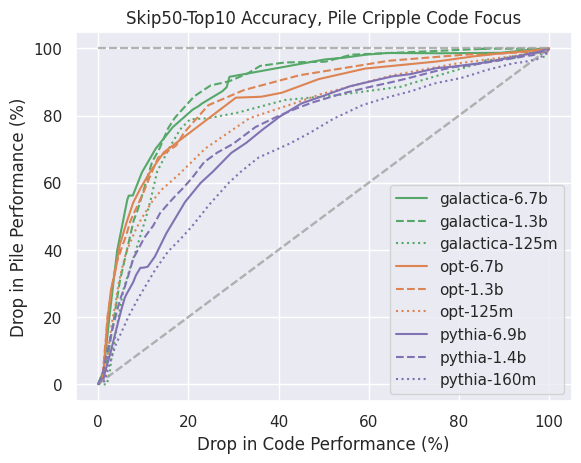

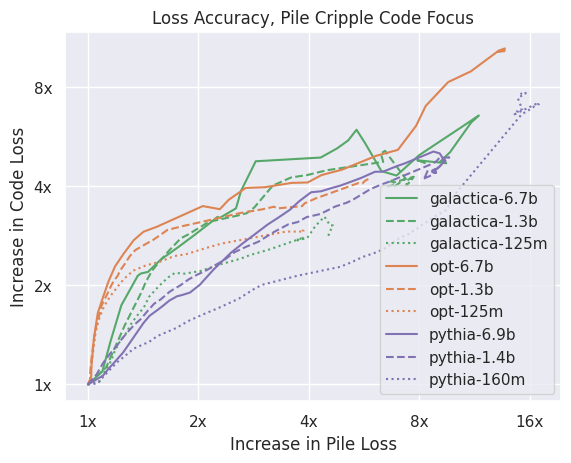

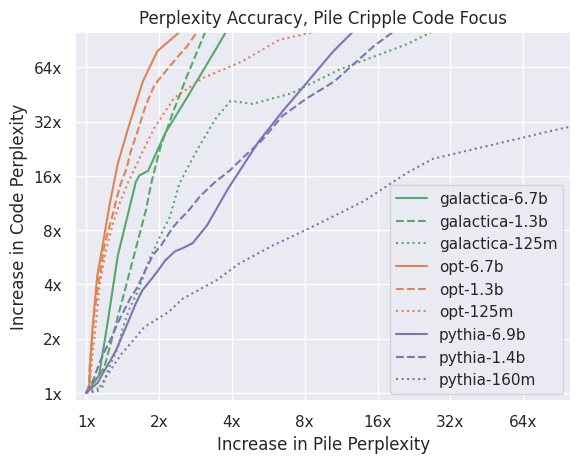

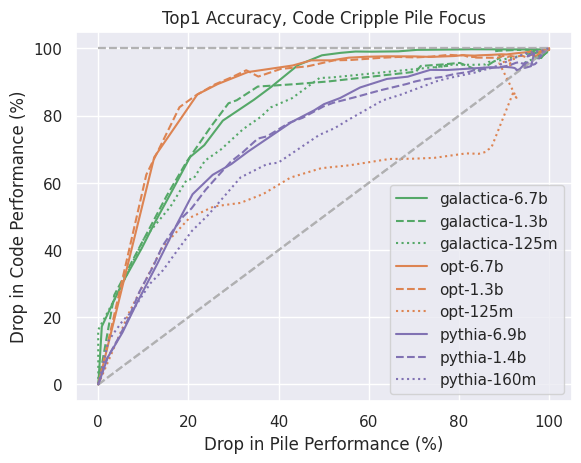

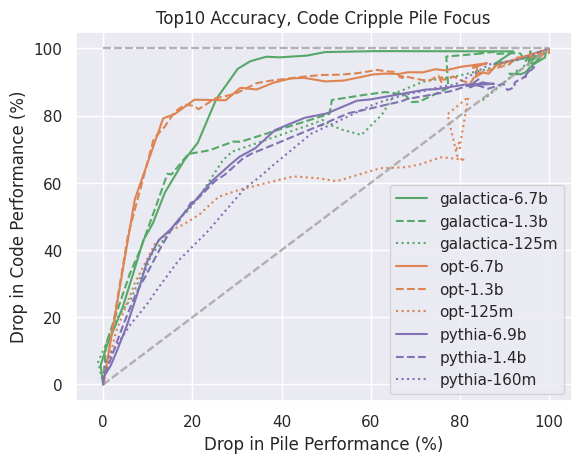

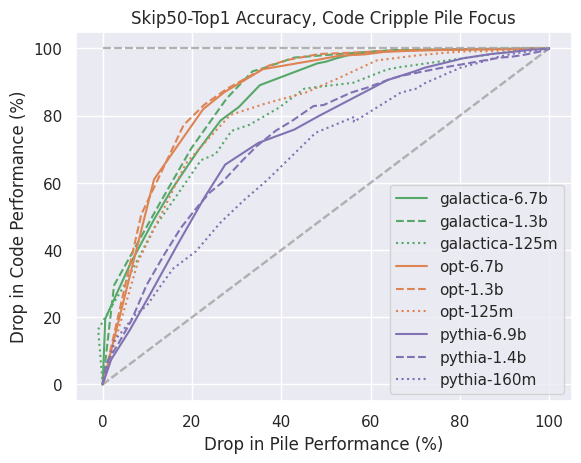

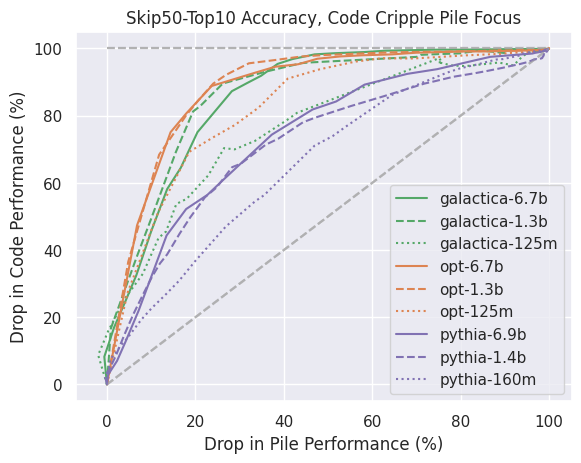

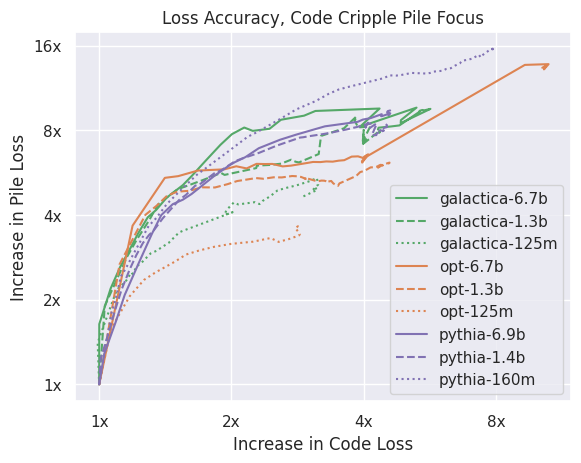

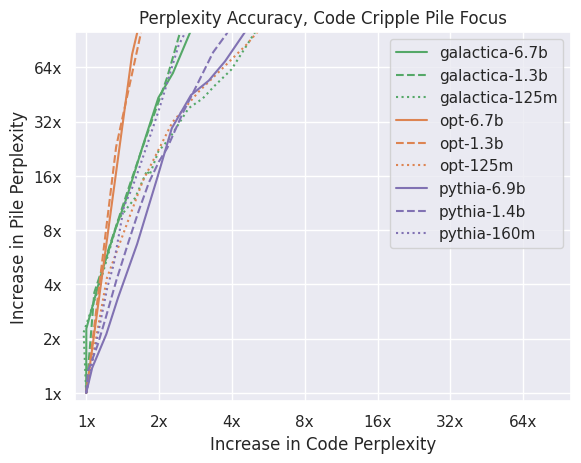

In [9]:
runs_filtered = filter_crashed_runs(_runs_pile_code, run_limit=None)
plot_best_metrics(runs_filtered, False) 

             Model  Top1  Top10  Skip50-Top1  Skip50-Top10
0   galactica-6.7b 0.161  0.170        0.231         0.261
1   galactica-1.3b 0.214  0.171        0.274         0.335
2   galactica-125m 0.058 -0.011        0.145         0.137
3         opt-6.7b 0.228  0.171        0.288         0.349
4         opt-1.3b 0.167  0.151        0.223         0.319
5         opt-125m 0.007  0.010        0.176         0.183
6      pythia-6.9B 0.104  0.063        0.193         0.167
7      pythia-1.4B 0.149  0.122        0.222         0.225
8      pythia-160m 0.087  0.078        0.164         0.150
9   galactica-6.7b 0.285  0.346        0.232         0.290
10  galactica-1.3b 0.256  0.256        0.219         0.266
11  galactica-125m 0.119  0.100        0.056         0.038
12        opt-6.7b 0.235  0.221        0.293         0.274
13        opt-1.3b 0.171  0.153        0.214         0.163
14        opt-125m 0.082  0.050        0.101         0.040
15     pythia-1.4B 0.104  0.084        0.054         0.0

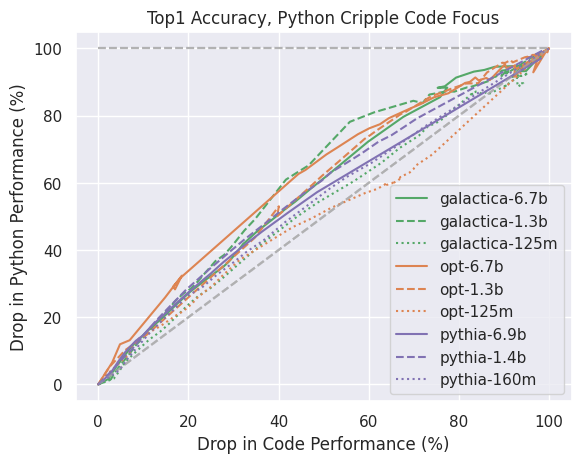

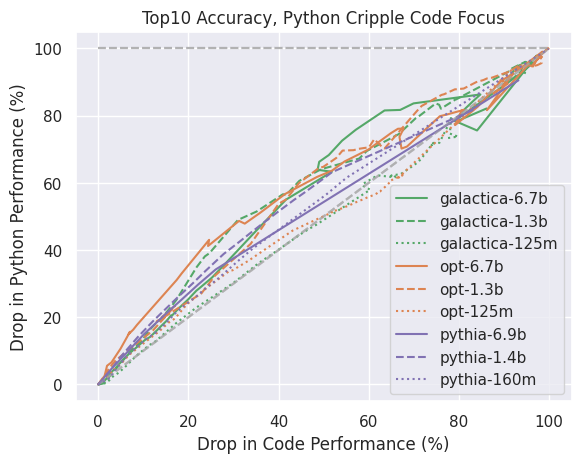

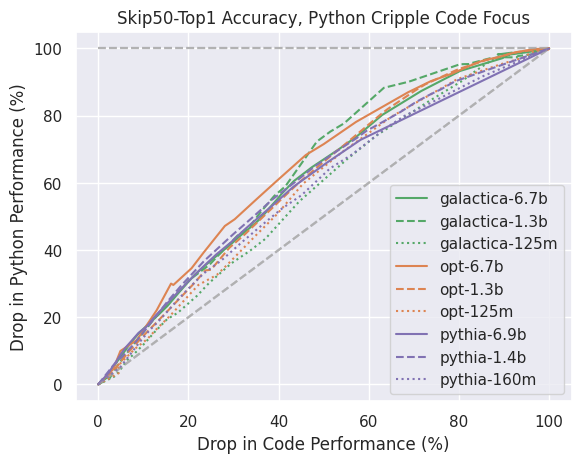

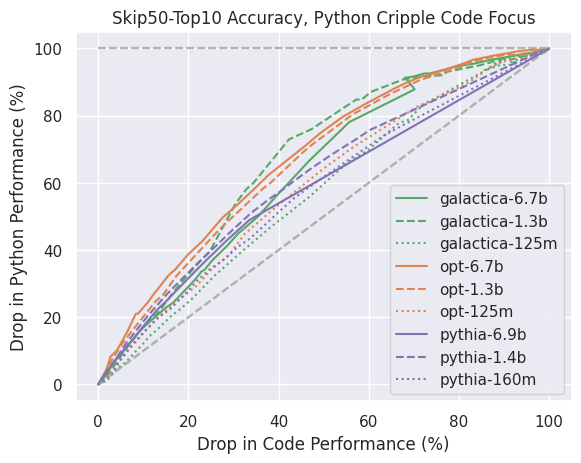

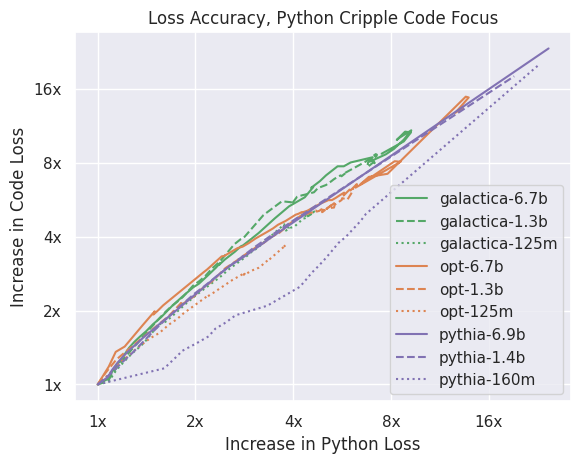

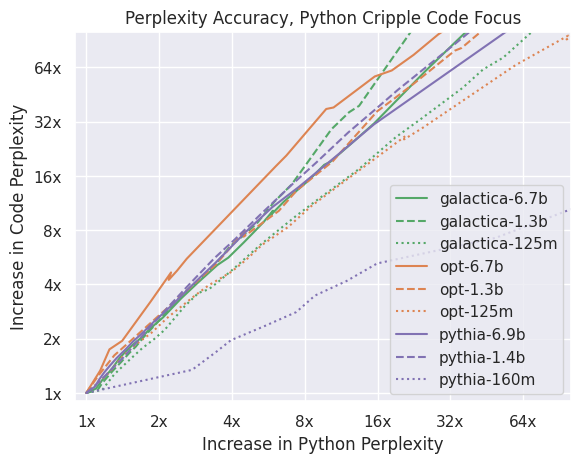

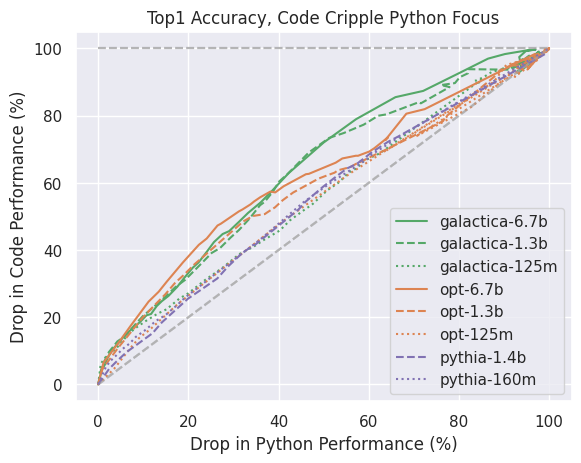

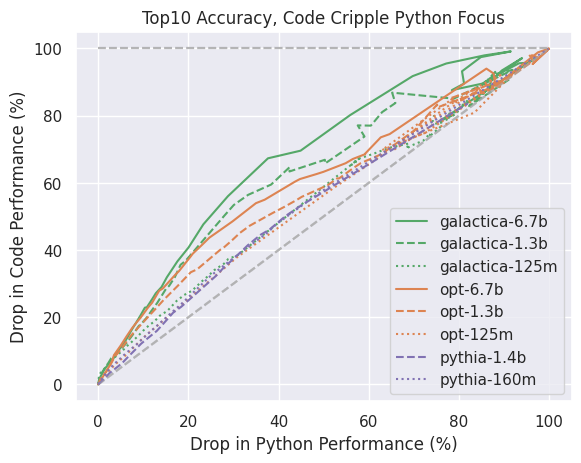

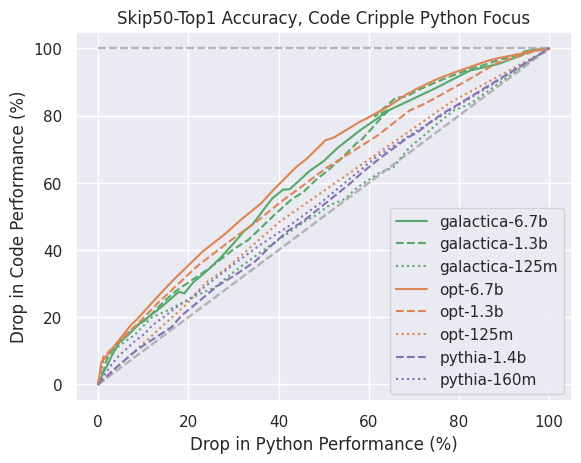

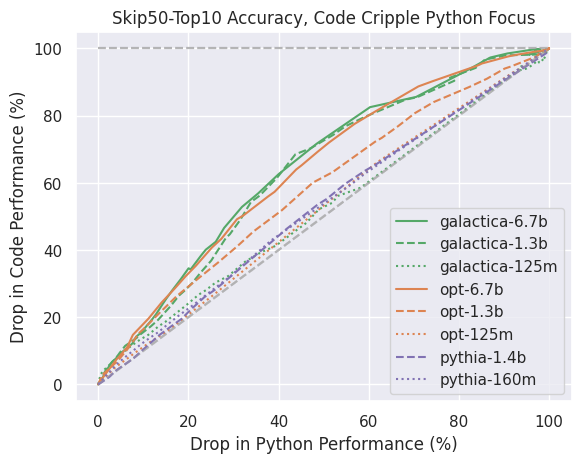

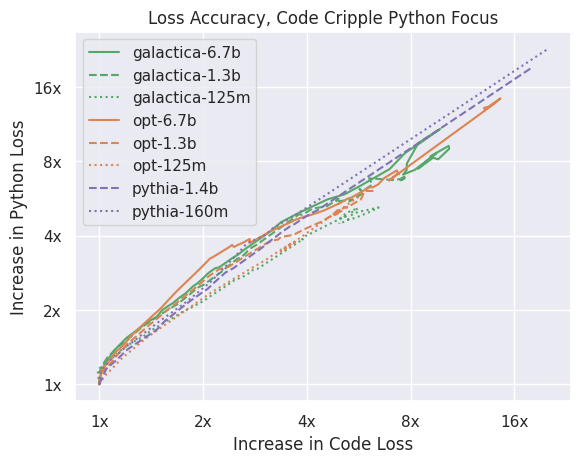

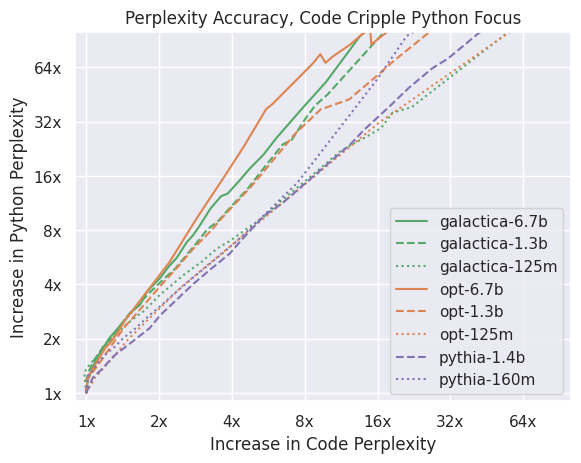

In [10]:
runs_filtered = filter_crashed_runs(_runs_code_python, run_limit=None)
plot_best_metrics(runs_filtered, False) 

gal 1.3b attn abs dict_items([('focus', 'pile'), ('ff_eps', 0.001), ('cripple', 'code'), ('ff_frac', 0), ('svd_attn', False), ('attn_frac', 0.05), ('model_size', 'facebook/galactica-1.3b'), ('token_limit', 1000), ('attn_scoring', 'abs'), ('run_pre_test', True), ('attn_prune_type', 'pre_out'), ('attn_prune_heads', False), ('svd_combine_biases', False), ('do_attn_mean_offset', False)])
gal 1.3b both svd dict_items([('focus', 'pile'), ('ff_eps', 0.001), ('cripple', 'code'), ('ff_frac', 0.05), ('svd_attn', True), ('attn_frac', 0.02), ('model_size', 'facebook/galactica-1.3b'), ('token_limit', 1000), ('attn_scoring', 'abs'), ('run_pre_test', True), ('attn_prune_type', 'pre_out'), ('attn_prune_heads', False), ('do_attn_mean_offset', False)])
gal 1.3b both dict_items([('focus', 'pile'), ('ff_eps', 0.001), ('cripple', 'code'), ('ff_frac', 0.05), ('svd_attn', False), ('attn_frac', 0.02), ('model_size', 'facebook/galactica-1.3b'), ('token_limit', 1000), ('attn_scoring', 'abs'), ('run_pre_test', T

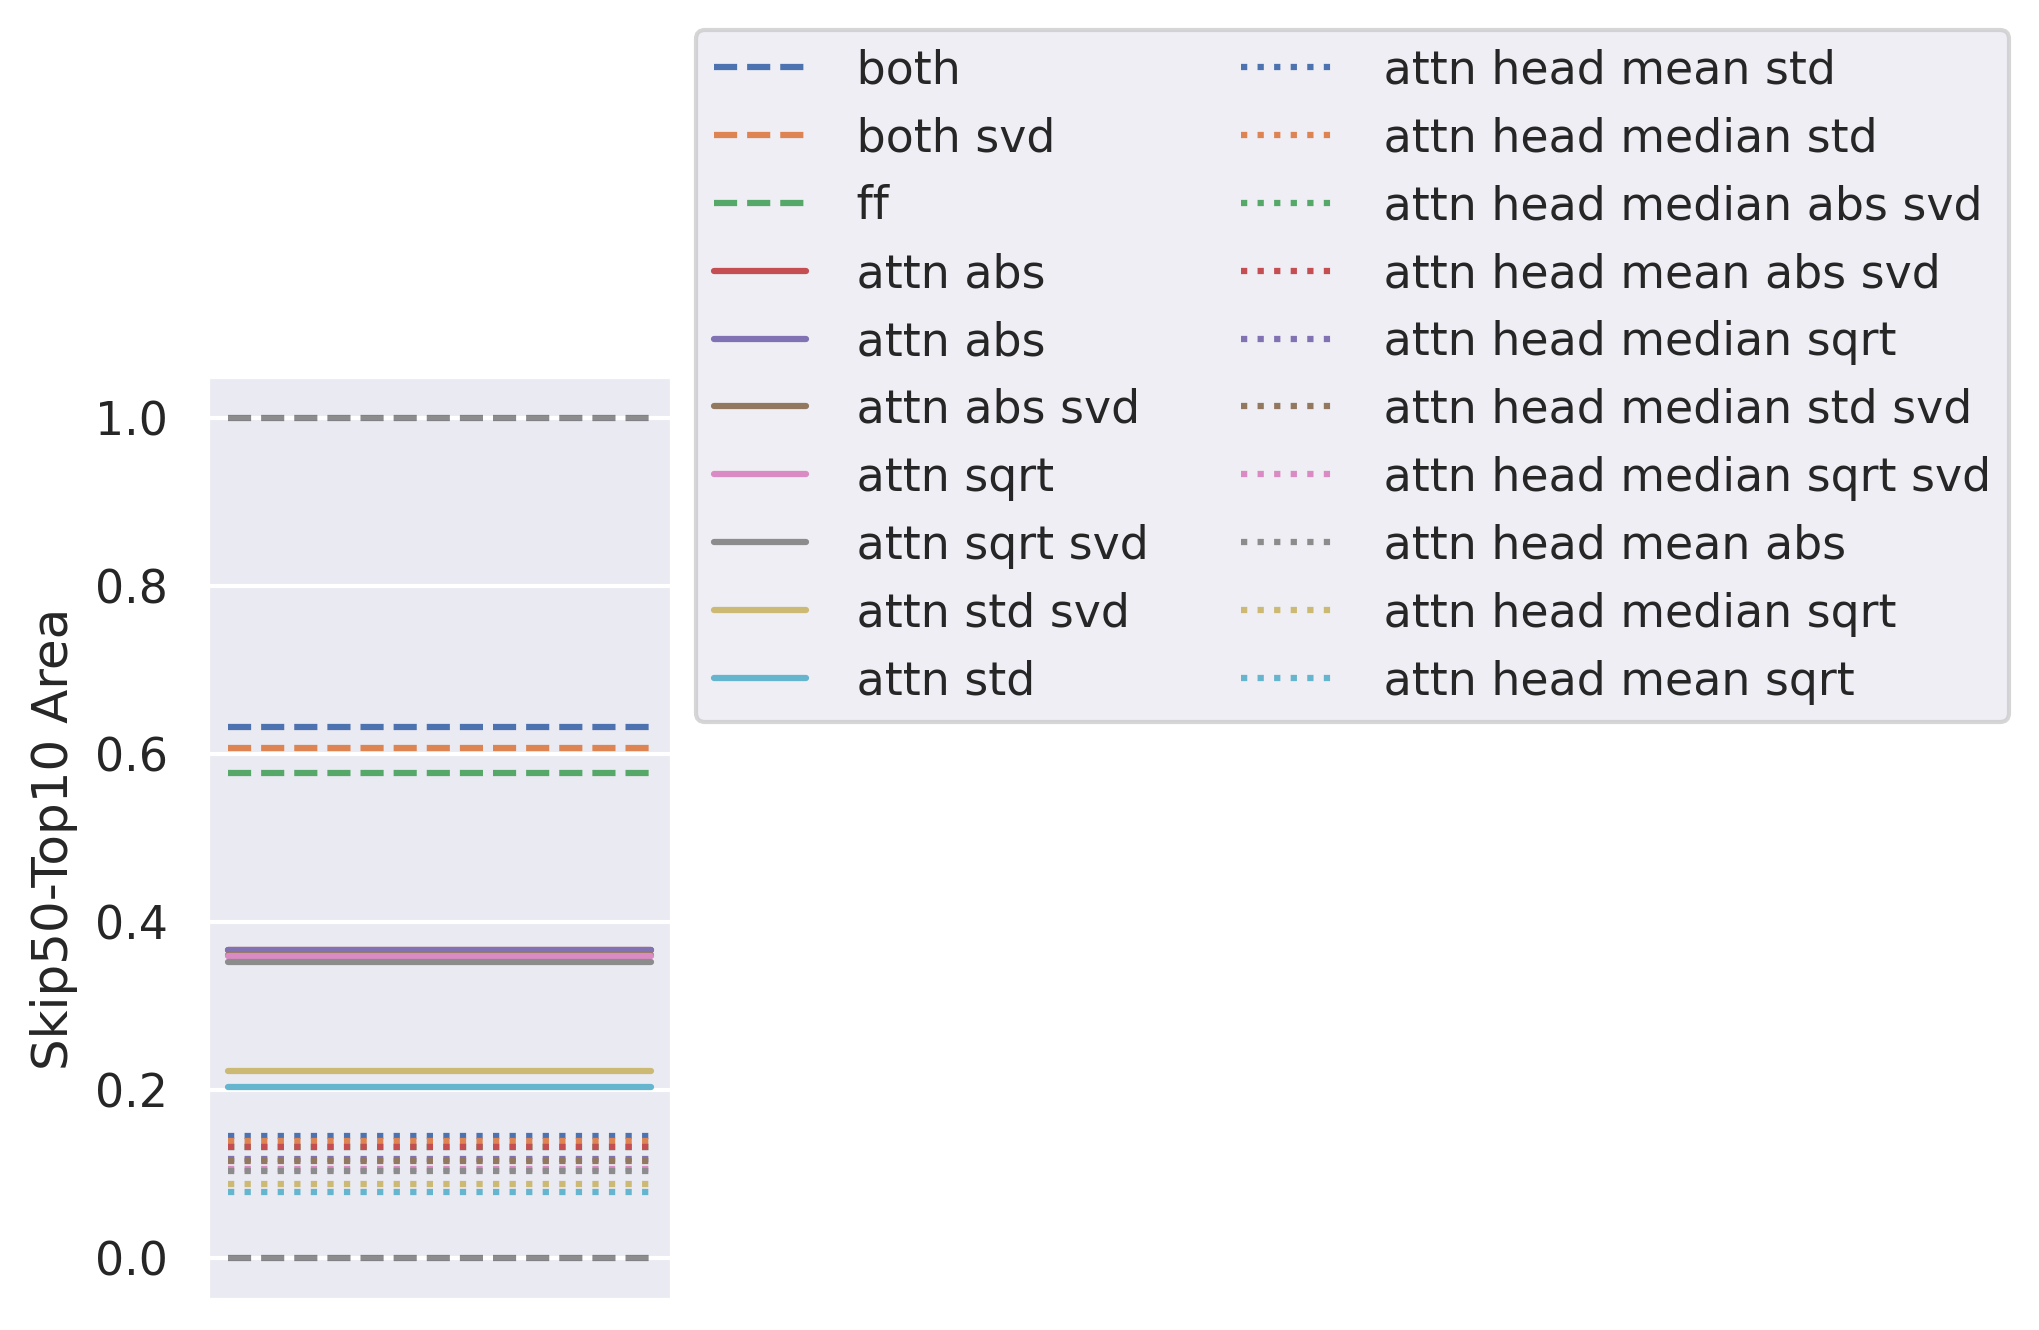

In [16]:
runs_filtered, run_limit = [], None
for run in _runs_attn:
    if run_limit and len(runs_filtered) > run_limit:
        break
    if run.state == "crashed":
        continue
    if not "_step" in run.summary or run.summary["_step"] < 1:
        continue
    #if not "attn" in run.name:
    #    continue
    if "rev" in run.name:
        continue
    if not run.config["model_size"] == "facebook/galactica-1.3b":
        continue
    if "L" in run.name:
        continue
    if run.name in [
            "gal 1.3b del bias attn abs",
            "gal 1.3b attn",
            "gal 1.3b both old",
            "gal 1.3b both svd-b",
        ]:
        continue
    print(run.name, run.config.items())
    runs_filtered.append(run.url)
   
areas = [] 
df = pd.DataFrame()
for run in runs_filtered:
    r = WandbRunData(run)
    x = 1-normed(r.h, "code", "topk_skip")
    y = 1-normed(r.h, "pile", "topk_skip")
    x = [*x, 1]
    y = [*y, 1]
    area =  1 - calculate_area(x, y)*2
    name = r.run.name.split("gal 1.3b")[-1]
    
    if "attn h" in name:
        h_type = "attn head " + r.run.config["attn_prune_heads"]
        name = h_type.join( name.split("attn h") )
    new_data = { "name": name, "area": area }
    df = df_append(df, new_data)
#    plt.plot([0, 1], [1, area], label = r.run.name)
df = df.sort_values(by="area", ascending=False)
l = len(df)

fig = plt.figure(figsize=(2,4), dpi=300)
ax = fig.gca()
#fig.title( "Different Pruning Strategies - Galactica 1.3B")
plt.ylabel("Skip50-Top10 Area")
for i, row in df.iterrows():
    linestyle = "-"
    if not "attn" in row["name"]:
        linestyle = "--"
    if "attn h" in row["name"]:
        linestyle = ":"
    plt.plot([0, 1], [row["area"], row["area"]], label=row["name"], linestyle=linestyle)
    print(row["name"], row["area"])

ax.set_xticks([])

plt.hlines(0, 0, 1, color="k", linestyle="--", alpha=0.5)
plt.hlines(1, 0, 1, color="k", linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=2)
print("Galactica 1.3B Pruning Method Comparison")
plt.show()